# Data preprocessing and spatial filtering

**Vilém Knap**

This notebook prepares all spatial datasets used in the analysis. The objective is to create a clean, spatially consistent set of layers that are restricted to the territory of the City of Prague and separated by public transport mode. No exploratory analysis or modelling is performed at this stage.

## 1. Purpose of preprocessing

The raw datasets used in this project originate from multiple public sources and differ in spatial extent, structure, and thematic scope. Before any analysis can be performed, the data must be:

- **spatially restricted to the territory of the City of Prague,**
- **harmonized across layers,**
- **and disaggregated by public transport mode.**

This preprocessing step ensures that all subsequent analyses operate on a consistent and well-defined spatial basis.


In [8]:
# --- Environment & global settings ---

import os
import geopandas as gpd
import numpy as np

TARGET_CRS = "EPSG:5514"

DATA_RAW = "data/raw"
DATA_PROC = "data/processed"
QC_DIR = os.path.join(DATA_PROC, "qc")

os.makedirs(DATA_PROC, exist_ok=True)
os.makedirs(QC_DIR, exist_ok=True)

### 1.a Utilities / QC plotting

add a small "QC map" cell after each output: a quick spot check of the extent + overlap with the Prague border. We will do it so that:

it is fast (without tmap/folium),

it works everywhere (matplotlib),

it is consistent (same function for all layers),

it can handle point/line/polygon.

In [29]:
import matplotlib.pyplot as plt

def qc_plot_layer(gdf, boundary=None, title="", figsize=(7, 7), markersize=2, linewidth=0.6):
    """
    Quick visual spotcheck for a GeoDataFrame.
    - boundary: GeoDataFrame with Prague boundary (optional)
    - works for points/lines/polygons
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Plot boundary first (if provided)
    if boundary is not None and len(boundary) > 0:
        boundary.boundary.plot(ax=ax, linewidth=1.2)

    geom_types = set(gdf.geom_type.unique())

    if "Point" in geom_types or "MultiPoint" in geom_types:
        gdf.plot(ax=ax, markersize=markersize)
    else:
        # lines or polygons
        gdf.plot(ax=ax, linewidth=linewidth)

    ax.set_title(title)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

## 2. Defining the spatial extent of Prague

To define the spatial extent of the analysis, administrative districts of Prague (RSO – správní obvody hlavního města Prahy) are used. The individual administrative polygons are aggregated into a single city-wide geometry representing the territory of Prague.

This derived boundary is used as a spatial mask to filter all transport-related datasets, ensuring that only features located within Prague are retained.


In [9]:
# --- Load administrative districts (RSO) ---

RSO_SHP = os.path.join(DATA_RAW, "rso_prague", "Spravni_obvody_hlavniho_mesta_Prahy_multi_20251001.shp")

rso = gpd.read_file(RSO_SHP)
rso = rso.to_crs(TARGET_CRS)

# Basic geometry fix
rso = rso[rso.geometry.notnull()].copy()
rso["geometry"] = rso.geometry.buffer(0)

print("RSO polygons:", len(rso))

RSO polygons: 22


In [10]:
# --- Dissolve into a single Prague boundary ---

prague_boundary = rso.dissolve()

# Save derived boundary
PRAGUE_BOUNDARY_PATH = os.path.join(DATA_PROC, "prague_boundary.gpkg")
prague_boundary.to_file(PRAGUE_BOUNDARY_PATH, driver="GPKG")

print("Prague boundary geometry type:", prague_boundary.geometry.iloc[0].geom_type)

Prague boundary geometry type: Polygon


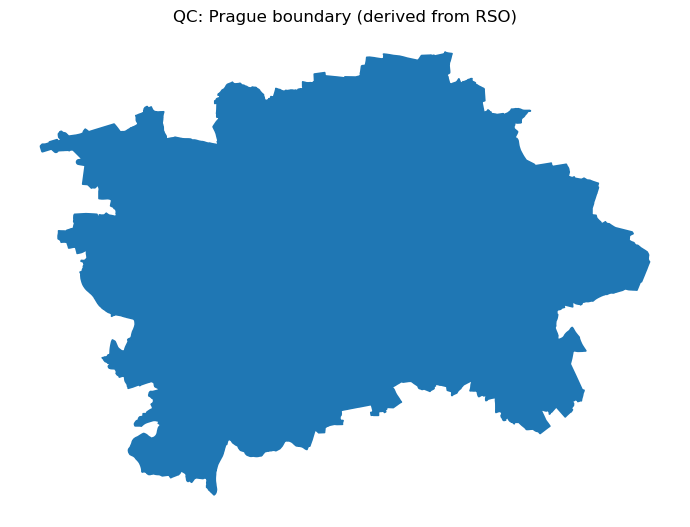

In [31]:
#Quick plot of an output to spotcheck
qc_plot_layer(prague_boundary, boundary=prague_boundary, title="QC: Prague boundary (derived from RSO)")

Prague boundary as unifed polygon looks good.

## 3. Filtering the public transport network to Prague

Public transport datasets obtained from national open data portals include services and infrastructure that extend beyond the administrative boundary of Prague.

To maintain analytical consistency, both stop and route geometries are spatially filtered using the derived Prague boundary. Only features whose geometries intersect the city boundary are retained. Route geometries are additionally clipped to the boundary to avoid retaining out-of-city segments.

This step ensures that the transport network used in subsequent analysis reflects only the internal structure of Prague’s integrated public transport system.

In [11]:
# --- Load public transport datasets (full extent) ---

STOPS_SHP = os.path.join(DATA_RAW, "pid_stops", "Zastavky_WGS84.shp")
ROUTES_SHP = os.path.join(DATA_RAW, "pid_routes", "Linky_WGS84.shp")

stops = gpd.read_file(STOPS_SHP).to_crs(TARGET_CRS)
routes = gpd.read_file(ROUTES_SHP).to_crs(TARGET_CRS)

print("Stops (raw):", len(stops))
print("Routes (raw):", len(routes))

Stops (raw): 16172
Routes (raw): 748


In [12]:
# --- Spatial filter: keep only features within Prague ---

boundary_geom = prague_boundary.geometry.iloc[0]

# Stops: intersection test
stops_prague = stops[stops.geometry.intersects(boundary_geom)].copy()

# Routes: clip to boundary
routes_prague = gpd.clip(routes, prague_boundary)

# Save filtered datasets
STOPS_PRAGUE_PATH = os.path.join(DATA_PROC, "stops_prague.gpkg")
ROUTES_PRAGUE_PATH = os.path.join(DATA_PROC, "routes_prague.gpkg")

stops_prague.to_file(STOPS_PRAGUE_PATH, driver="GPKG")
routes_prague.to_file(ROUTES_PRAGUE_PATH, driver="GPKG")

print("Stops (Prague):", len(stops_prague))
print("Routes (Prague):", len(routes_prague))

Stops (Prague): 3502
Routes (Prague): 362


**Quick plotting of outputs to spotcheck**


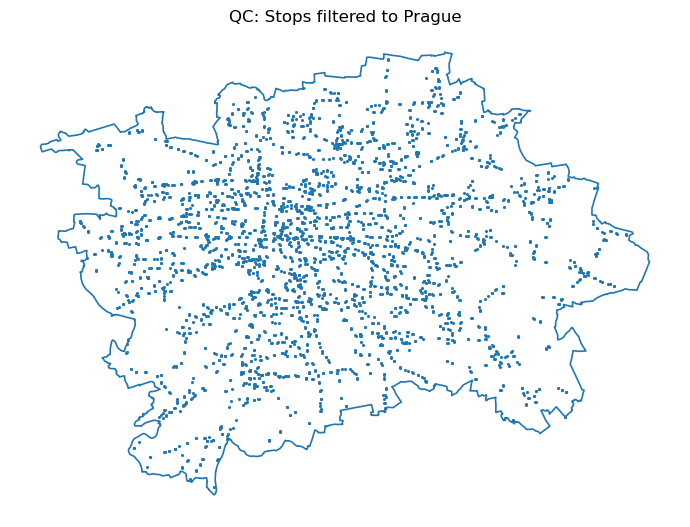

In [35]:
qc_plot_layer(stops_prague, boundary=prague_boundary, title="QC: Stops filtered to Prague", markersize=1.5)

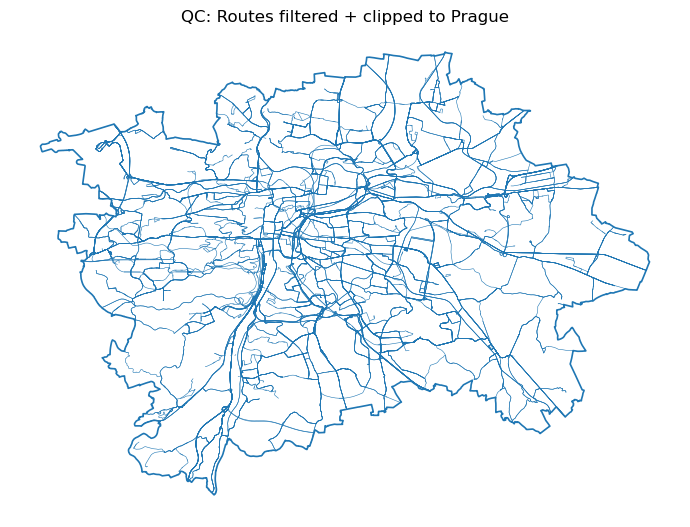

In [33]:
qc_plot_layer(routes_prague, boundary=prague_boundary, title="QC: Routes filtered + clipped to Prague", linewidth=0.4)

Looks good, both stops and routes has been correctly clipped to contain features only in the inside of Prague administrative boundaries. 

## 4. Public transport modes and attribute-based filtering

The Prague Integrated Transport datasets encode transport modes using the attribute `Route_type`. This attribute allows each route and stop to be classified by the dominant mode of transport.

The following encoding is used:

- 0 – tram
- 1 – metro
- 2 – rail
- 3 – bus
- 4 – ferry
- 7 – funicular

For the purposes of this project, transport services are filtered by mode to enable mode-specific accessibility measures. In particular, metro, tram, bus, and rail are retained, while ferry and funicular services are excluded due to their limited spatial relevance for residential accessibility.

In [24]:
# --- Detect route_type column separately for routes and stops ---

def find_column(cols, candidates):
    cols_lower = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    for c in cols:
        for cand in candidates:
            if cand.lower() in c.lower():
                return c
    return None

ROUTE_TYPE_COL_ROUTES = find_column(routes_prague.columns, ["route_type", "Route_type", "ROUTE_TYPE", "routetype"])
ROUTE_TYPE_COL_STOPS  = find_column(stops_prague.columns,  ["route_type", "Route_type", "ROUTE_TYPE", "routetype"])

print("Route type column (routes):", ROUTE_TYPE_COL_ROUTES)
print("Route type column (stops): ", ROUTE_TYPE_COL_STOPS)

if ROUTE_TYPE_COL_ROUTES is None:
    raise ValueError("Route type column not found in routes_prague.")
if ROUTE_TYPE_COL_STOPS is None:
    raise ValueError("Route type column not found in stops_prague.")


Route type column (routes): route_type
Route type column (stops):  route_type


In [25]:
# --- Normalize route_type fields (string -> integer codes) ---

def normalize_route_type_to_int(series):
    """
    Converts route_type-like series to Int64.
    Handles string values like '3', ' 3', and missing values.
    """
    s = series.astype(str).str.strip()
    s = s.replace({"nan": np.nan, "None": np.nan, "": np.nan})
    # convert to numeric (Int64 supports NA)
    return gpd.pd.to_numeric(s, errors="coerce").astype("Int64")

routes_prague[ROUTE_TYPE_COL_ROUTES] = normalize_route_type_to_int(routes_prague[ROUTE_TYPE_COL_ROUTES])
stops_prague[ROUTE_TYPE_COL_STOPS]   = stops_prague[ROUTE_TYPE_COL_STOPS].astype(str).str.strip()

print("Routes route_type distribution:")
print(routes_prague[ROUTE_TYPE_COL_ROUTES].value_counts(dropna=False).head(10))


Routes route_type distribution:
route_type
3    286
0     35
2     31
4      6
1      3
7      1
Name: count, dtype: Int64


In [18]:
# --- Mode encoding (Prague Integrated Transport) ---

MODE_CODES = {
    "tram": 0,
    "metro": 1,
    "rail": 2,
    "bus": 3
}

EXCLUDED_CODES = {4, 7}  # ferry, funicular

## 5. Mode-specific filtering: routes

Stops are filtered using the `Route_type` attribute associated with each stop. In cases where a stop is served by multiple modes (e.g., tram and bus), the stop is retained in each relevant mode-specific dataset.

This approach reflects the functional reality of multimodal stops while allowing mode-specific proximity measures to be computed independently in later stages.

**Outputs:** 

- `routes_tram.gpkg`

- `routes_metro.gpkg`

- `routes_bus.gpkg`

- `routes_rail.gpkg`


In [26]:
MODE_CODES = {"tram": 0, "metro": 1, "rail": 2, "bus": 3}
EXCLUDED_CODES = {4, 7}

routes_by_mode = {}

for mode, code in MODE_CODES.items():
    gdf = routes_prague[routes_prague[ROUTE_TYPE_COL_ROUTES] == code].copy()
    routes_by_mode[mode] = gdf
    print(f"Routes ({mode}):", len(gdf))


Routes (tram): 35
Routes (metro): 3
Routes (rail): 31
Routes (bus): 286


In [27]:
# --- Save mode-specific route layers ---

for mode, gdf in routes_by_mode.items():
    out_path = os.path.join(DATA_PROC, f"routes_{mode}.gpkg")
    gdf.to_file(out_path, driver="GPKG")

In [28]:
# QC: excluded modes present?
excluded_routes = routes_prague[routes_prague[ROUTE_TYPE_COL_ROUTES].isin(list(EXCLUDED_CODES))].copy()
print("Excluded route features (ferry/funicular):", len(excluded_routes))

Excluded route features (ferry/funicular): 7


**Quick plotting of outputs to spotcheck**


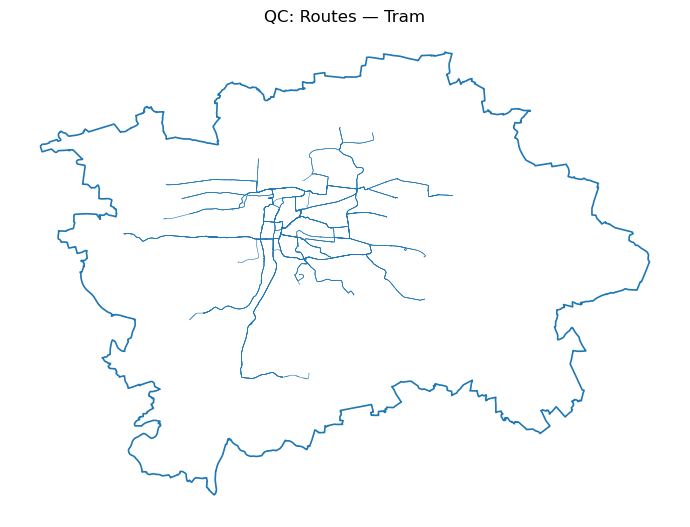

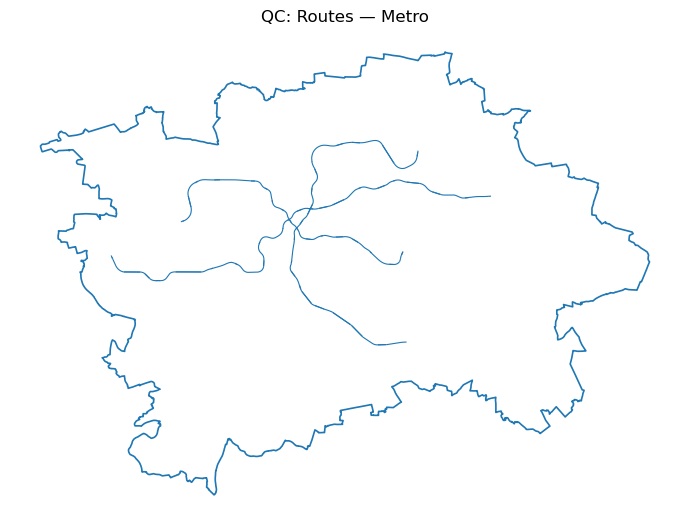

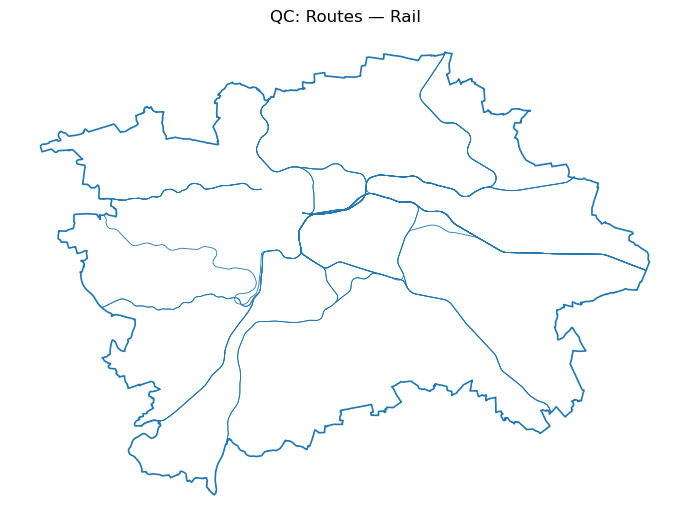

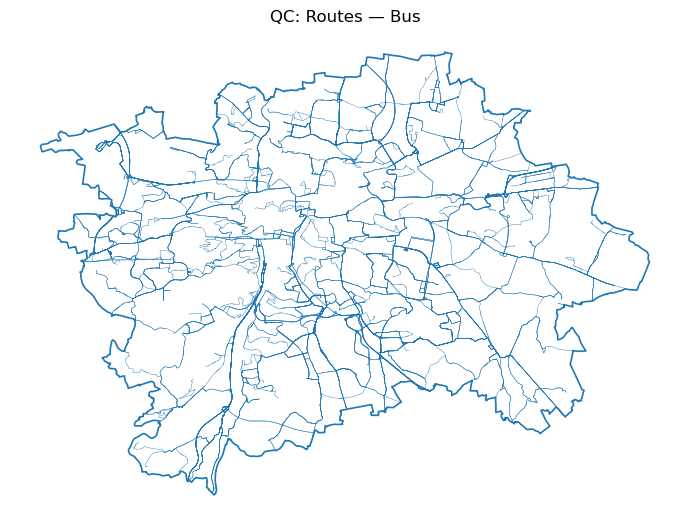

In [36]:
qc_plot_layer(routes_by_mode["tram"], boundary=prague_boundary, title="QC: Routes — Tram", linewidth=0.4)
qc_plot_layer(routes_by_mode["metro"], boundary=prague_boundary, title="QC: Routes — Metro", linewidth=0.8)
qc_plot_layer(routes_by_mode["rail"], boundary=prague_boundary, title="QC: Routes — Rail", linewidth=0.6)
qc_plot_layer(routes_by_mode["bus"], boundary=prague_boundary, title="QC: Routes — Bus", linewidth=0.3)

Looks good, all routes have been correctly sorted for each mode and correctly clipped to contain features only in the inside of Prague administrative boundaries

## 6. Mode-specific filtering: stops

Stops are filtered using the route_type attribute. Unlike routes, stops may be served by multiple modes.
In such cases, the stop is retained in each corresponding mode-specific dataset (e.g. a stop with route_type = "0,3" appears in both tram and bus stop layers).

This preserves multimodal reality while enabling independent proximity measures by mode.


**Outputs:**:

- `stops_tram.gpkg`

- `stops_metro.gpkg`

- `stops_bus.gpkg`

- `stops_rail.gpkg`

In [37]:
def stop_has_mode(route_type_value, code):
    """
    Returns True if a stop route_type contains the given mode code.
    Handles values like '0', '3', '0,3', '0, 3'.
    """
    if route_type_value is None:
        return False
    s = str(route_type_value).strip()
    if s.lower() in {"nan", "none", ""}:
        return False
    parts = [p.strip() for p in s.split(",")]
    return str(code) in parts

stops_by_mode = {}

for mode, code in MODE_CODES.items():
    mask = stops_prague[ROUTE_TYPE_COL_STOPS].apply(lambda v: stop_has_mode(v, code))
    stops_by_mode[mode] = stops_prague[mask].copy()
    print(f"Stops ({mode}):", len(stops_by_mode[mode]))


Stops (tram): 594
Stops (metro): 120
Stops (rail): 47
Stops (bus): 2820


In [38]:
# --- Save mode-specific stop layers ---

for mode, gdf in stops_by_mode.items():
    out_path = os.path.join(DATA_PROC, f"stops_{mode}.gpkg")
    gdf.to_file(out_path, driver="GPKG")


In [39]:
# QC: how many multimodal stops?
rt = stops_prague[ROUTE_TYPE_COL_STOPS].astype(str)
multimodal = rt.str.contains(",", regex=False).sum()
print("Multimodal stops (contains comma):", int(multimodal))

Multimodal stops (contains comma): 144


**Quick plotting of outputs to spotcheck**


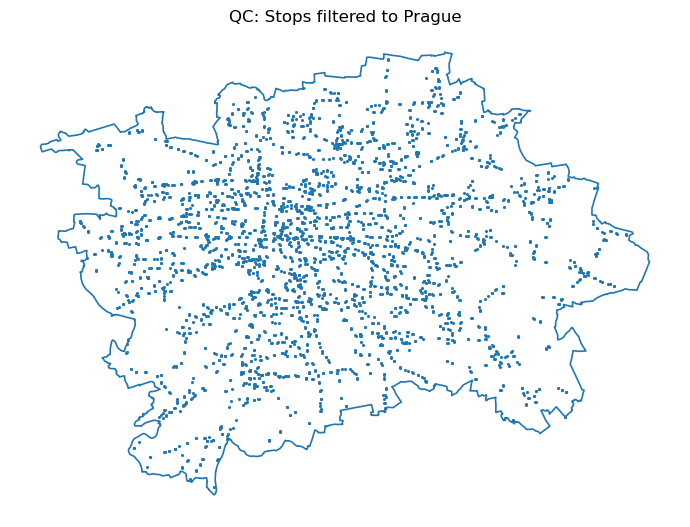

In [40]:
qc_plot_layer(stops_prague, boundary=prague_boundary, title="QC: Stops filtered to Prague", markersize=1.5)

**Mode-specific stops**

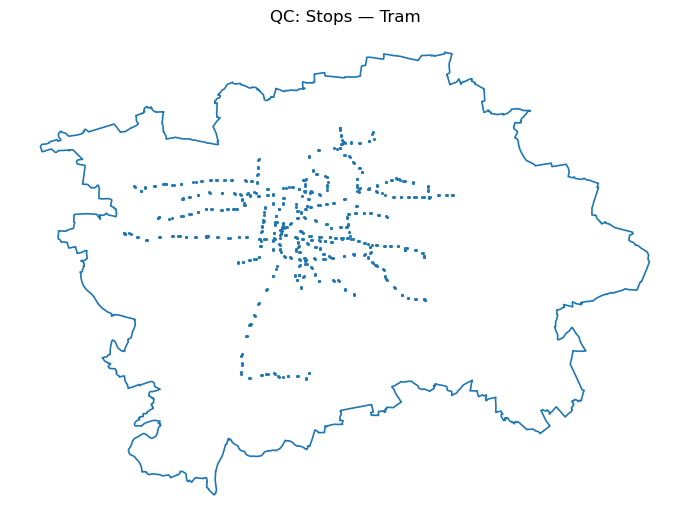

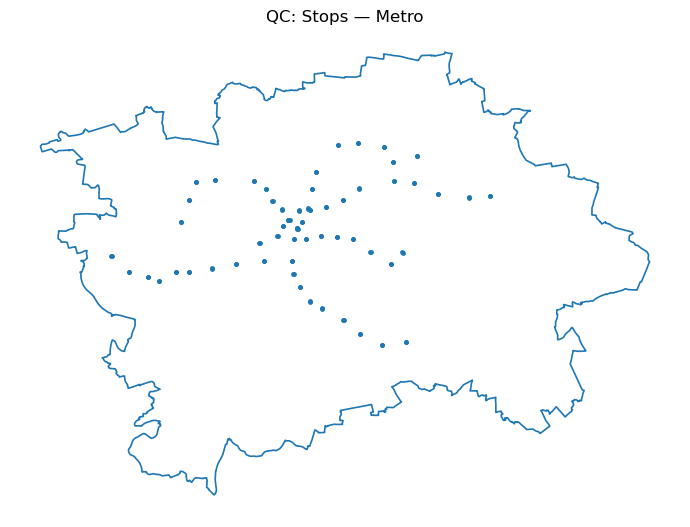

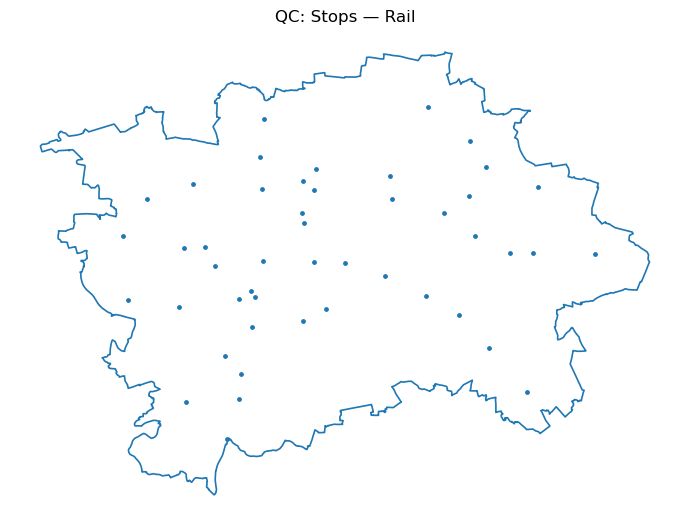

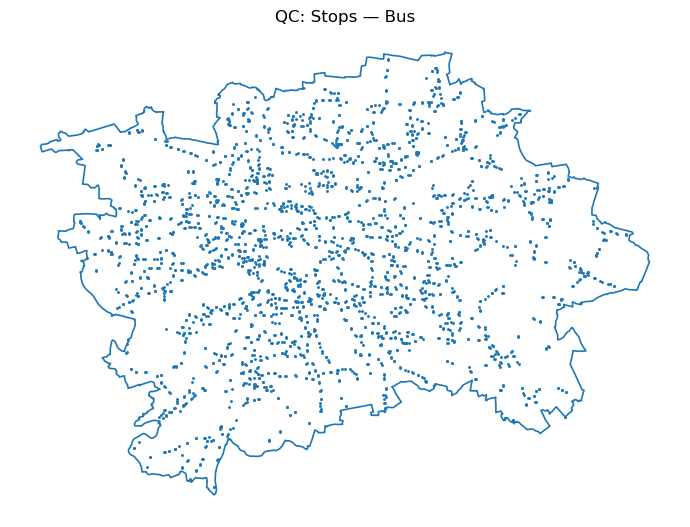

In [44]:
qc_plot_layer(stops_by_mode["tram"], boundary=prague_boundary, title="QC: Stops — Tram", markersize=1.5)
qc_plot_layer(stops_by_mode["metro"], boundary=prague_boundary, title="QC: Stops — Metro", markersize=6)
qc_plot_layer(stops_by_mode["rail"], boundary=prague_boundary, title="QC: Stops — Rail", markersize=6)
qc_plot_layer(stops_by_mode["bus"], boundary=prague_boundary, title="QC: Stops — Bus", markersize=1.2)

Looks good, all stops have been correctly sorted for each mode and correctly clipped to contain features only in the inside of Prague administrative boundaries

## 7. Preparing the land price map

The land price map is provided as a polygon layer where each polygon represents an aggregated land-value zone with an assigned average price (CZK per m²) and polygon area. These zones do not correspond to individual parcels or buildings; they are valuation units intended for planning-level analysis.

To ensure spatial consistency, the land price map is reprojected to the common CRS.

**Output**:
- `price_map.gpkg` 

In [45]:
### Load shapefiles and spotcheck
import os
import geopandas as gpd

TARGET_CRS = "EPSG:5514"

PRICE_SHP = r"data\raw\price_map\SED_CENOVAMAPA_P.shp"
AUP_SHP   = r"data\raw\area_usage\PVP_FVU_P.shp"

OUT_DIR = "data/processed"
QC_DIR  = "data/processed/qc"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(QC_DIR, exist_ok=True)

price = gpd.read_file(PRICE_SHP)
aup   = gpd.read_file(AUP_SHP)

print("PRICE columns:", list(price.columns))
print("AUP columns:", list(aup.columns))

price = price.to_crs(TARGET_CRS)
aup   = aup.to_crs(TARGET_CRS)


C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\pyogrio\raw.py:200: RuntimeWarning: organizePolygons() received an unexpected geometry.  Either a polygon with interior rings, or a polygon with less than 4 points, or a non-Polygon geometry.  Return arguments as a collection.
  return ogr_read(
C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\pyogrio\raw.py:200: RuntimeWarning: Geometry of polygon of fid 5859 cannot be translated to Simple Geometry. All polygons will be contained in a multipolygon.
  return ogr_read(


PRICE columns: ['KOD_UNI', 'CENA', 'SHAPE_LEN', 'geometry']
AUP columns: ['KODFP1_A', 'ZAS1', 'CSO1', 'KODFP2_A', 'ZAS2', 'CSO2', 'POPIS', 'POPIS_Z', 'ZDROJ', 'ZAS1_S', 'SHAPE_LEN', 'geometry']


Invalid geometries were detected. Need to perform sanity check and hotfix.

In [47]:
# Quick QC: geometry types + invalidity + empty
def geom_qc(gdf, name):
    print(f"\n--- QC: {name} ---")
    print("rows:", len(gdf))
    print("crs:", gdf.crs)
    print("geom types:", gdf.geom_type.value_counts(dropna=False).to_dict())
    print("empty geoms:", int(gdf.geometry.is_empty.sum()))
    print("null geoms:", int(gdf.geometry.isna().sum()))
    try:
        invalid = (~gdf.geometry.is_valid).sum()
        print("invalid geoms:", int(invalid))
    except Exception as e:
        print("is_valid check failed:", repr(e))

geom_qc(price, "PRICE (raw)")
geom_qc(aup,   "AUP (raw)")


--- QC: PRICE (raw) ---
rows: 9282
crs: EPSG:5514
geom types: {'Polygon': 9278, 'MultiPolygon': 4}
empty geoms: 0
null geoms: 0
invalid geoms: 10

--- QC: AUP (raw) ---
rows: 15425
crs: EPSG:5514
geom types: {'Polygon': 15425}
empty geoms: 0
null geoms: 0
invalid geoms: 19


In [49]:
#Fixing geometries by applying make_valid fom shapely package.
from shapely.validation import make_valid

def fix_geometries_make_valid(gdf):
    gdf = gdf[gdf.geometry.notnull() & (~gdf.geometry.is_empty)].copy()
    gdf["geometry"] = gdf.geometry.apply(make_valid)
    # po make_valid může vzniknout GeometryCollection → vyfiltruj jen polygonální části
    gdf = gdf[gdf.geom_type.isin(["Polygon", "MultiPolygon"])].copy()
    return gdf

price_fixed = fix_geometries_make_valid(price)
aup_fixed   = fix_geometries_make_valid(aup)

geom_qc(price_fixed, "PRICE (fixed)")
geom_qc(aup_fixed,   "AUP (fixed)")


--- QC: PRICE (fixed) ---
rows: 9281
crs: EPSG:5514
geom types: {'Polygon': 9277, 'MultiPolygon': 4}
empty geoms: 0
null geoms: 0
invalid geoms: 0

--- QC: AUP (fixed) ---
rows: 15425
crs: EPSG:5514
geom types: {'Polygon': 15425}
empty geoms: 0
null geoms: 0
invalid geoms: 0


In [50]:
def qc_export_invalid(gdf, name, out_path):
    invalid_mask = ~gdf.geometry.is_valid
    inv = gdf[invalid_mask].copy()
    print(f"{name}: invalid before export:", len(inv))
    if len(inv) > 0:
        inv.to_file(out_path, driver="GPKG")

qc_export_invalid(price, "PRICE", os.path.join(QC_DIR, "invalid_price_raw.gpkg"))
qc_export_invalid(aup,   "AUP",   os.path.join(QC_DIR, "invalid_aup_raw.gpkg"))

PRICE: invalid before export: 10
AUP: invalid before export: 19


In total, 29 invalid features has been fixed after performing validation.

**Quick plotting of outputs to spotcheck**


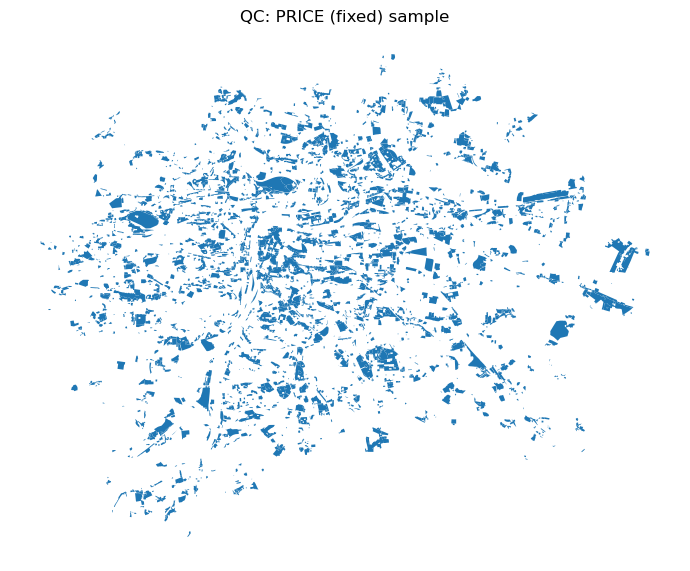

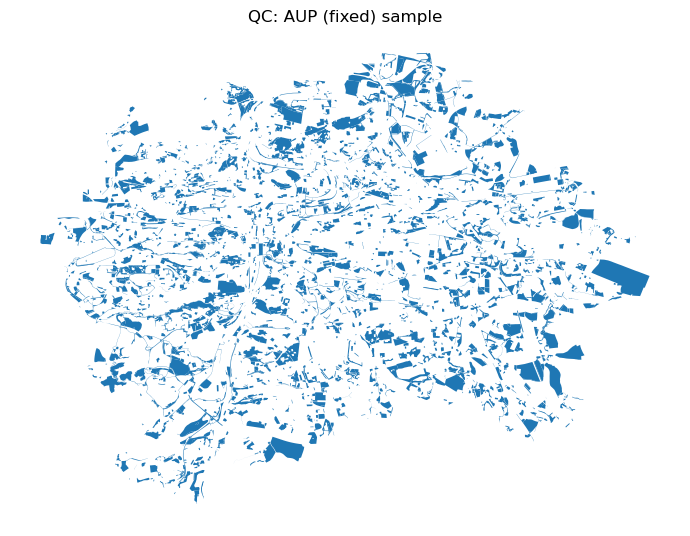

In [51]:
qc_plot_layer(price_fixed.sample(min(3000, len(price_fixed))), title="QC: PRICE (fixed) sample", linewidth=0.2)
qc_plot_layer(aup_fixed.sample(min(3000, len(aup_fixed))), title="QC: AUP (fixed) sample", linewidth=0.2)


After spotchecking, no visual artefacts were detected.

## 8. Residential filtering of the land price map using the land-use plan

Since the research question is motivated by residential location choice and walking accessibility to public transport, not all land-use categories are relevant. Industrial and certain commercial areas follow different accessibility logics where proximity to public transport is secondary or irrelevant.

Residential and mixed residential areas are identified using the Area Usage Plan (zoning) dataset. From the full land-use classification, four categories are retained:

- OB – čistě obytné (pure residential)
- OV – všeobecně obytné (general residential)
- SV – všeobecně smíšené (general mixed)
- SMJ – smíšené městského jádra (city core mix)

These land-use polygons define a “residential mask”. Price-map polygons are then labelled as residential if they fall within this mask. Because polygon layers from different sources may contain minor boundary mismatches or invalid geometries, the classification is performed using centroid containment with a representative-point fallback. All edge cases are exported for quality control.

**Outputs**
- `residential_mask.gpkg`
- `price_residential.gpkg`
- `qc/edge_cases_centroid_failed_repr_ok.gpkg`

### 8.1 Detect land-use code column in AUP

In [53]:
# --- Detect land-use code column (AUP) ---

def find_column(cols, candidates):
    cols_lower = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    for c in cols:
        for cand in candidates:
            if cand.lower() in c.lower():
                return c
    return None

AUP_CODE_COL = find_column(
    aup_fixed.columns,
    ["KOD", "KOD_FUNKCE", "FUNKCE", "FUNKTYP", "TYP", "CODE", "KOD_", "KODFVU", "FVU", "KOD_FVU"]
)

print("Detected AUP land-use code column:", AUP_CODE_COL)
print("AUP columns:", list(aup_fixed.columns))

if AUP_CODE_COL is None:
    raise ValueError("Could not detect land-use code column in AUP dataset.")

Detected AUP land-use code column: KODFP1_A
AUP columns: ['KODFP1_A', 'ZAS1', 'CSO1', 'KODFP2_A', 'ZAS2', 'CSO2', 'POPIS', 'POPIS_Z', 'ZDROJ', 'ZAS1_S', 'SHAPE_LEN', 'geometry']


### 8.2 Filter AUP to residential and mixed classes + export

In [54]:
# --- Filter AUP to target classes (OB/OV/SV/SMJ) ---

RES_CODES = {"OB", "OV", "SV", "SMJ"}

aup_fixed[AUP_CODE_COL] = aup_fixed[AUP_CODE_COL].astype(str).str.strip()

aup_res = aup_fixed[aup_fixed[AUP_CODE_COL].isin(RES_CODES)].copy()

print("AUP residential polygons:", len(aup_res))
print("AUP residential code distribution:")
print(aup_res[AUP_CODE_COL].value_counts().to_dict())


AUP residential polygons: 5373
AUP residential code distribution:
{'OB': 2361, 'SV': 1912, 'OV': 981, 'SMJ': 119}


**Optional: spatially restrict to Prague boundary (recommended):**

In [55]:
# Optional: clip AUP to Prague boundary for consistency
aup_res = gpd.clip(aup_res, prague_boundary)
print("AUP residential polygons (clipped to Prague):", len(aup_res))

AUP residential polygons (clipped to Prague): 5373


**Export filtered layer:**

In [56]:
AUP_RES_PATH = os.path.join(OUT_DIR, "aup_residential.gpkg")
aup_res.to_file(AUP_RES_PATH, driver="GPKG")

**Quick check plot:**

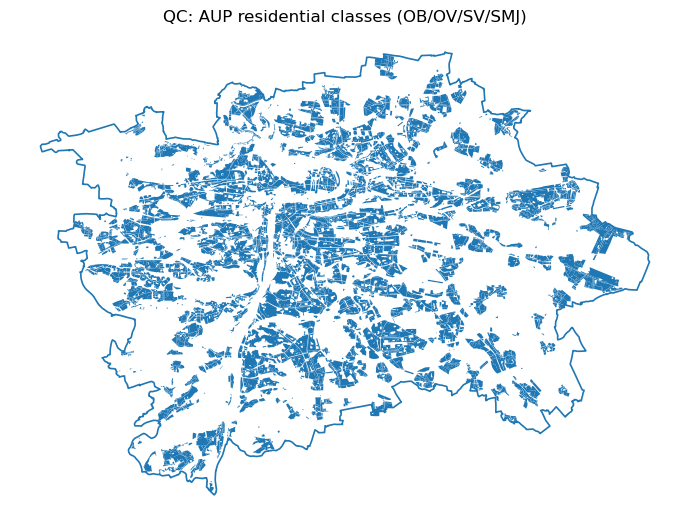

In [59]:
qc_plot_layer(aup_res, boundary=prague_boundary, title="QC: AUP residential classes (OB/OV/SV/SMJ)", linewidth=0.25)


Boundary polygons have been clipped correctly.

### 8.3 Build a single residential mask geometry (union/dissolve)

C:\Users\Vilem\AppData\Local\Temp\ipykernel_21236\1709288598.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  res_mask_geom = aup_res.geometry.unary_union


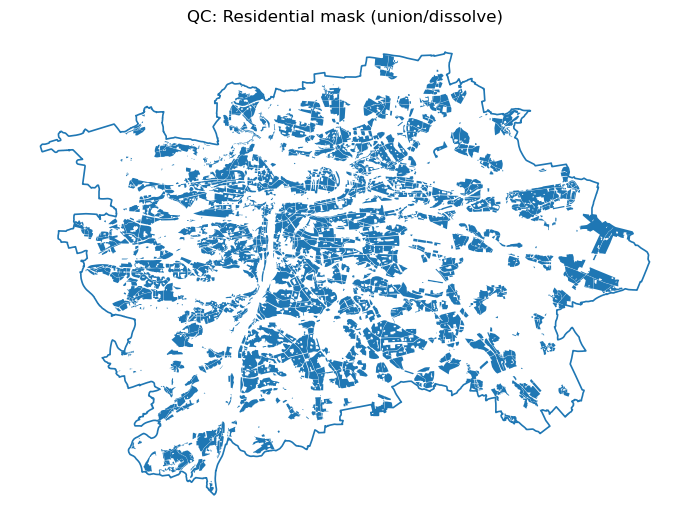

In [61]:
# --- Build residential mask (union) ---

res_mask_geom = aup_res.geometry.unary_union
residential_mask = gpd.GeoDataFrame(geometry=[res_mask_geom], crs=TARGET_CRS)

RES_MASK_PATH = os.path.join(OUT_DIR, "residential_mask.gpkg")
residential_mask.to_file(RES_MASK_PATH, driver="GPKG")

qc_plot_layer(residential_mask, boundary=prague_boundary, title="QC: Residential mask (union/dissolve)", linewidth=0.8)


### 8.4 Prepare land price layer (optional clip to Prague)

Price polygons (clipped to Prague): 9281


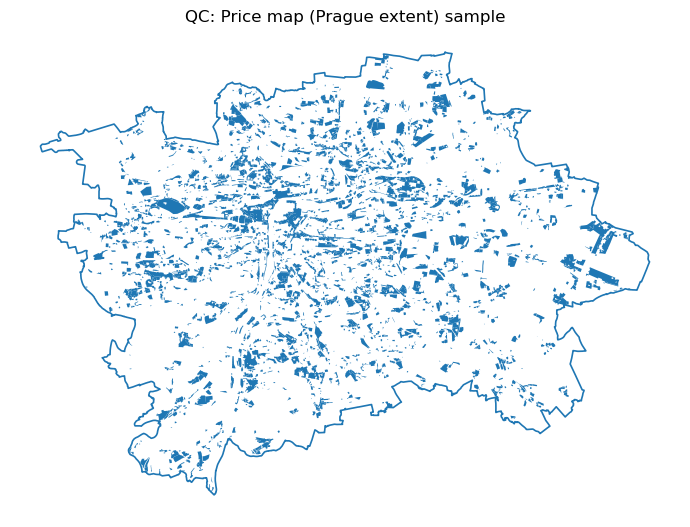

In [62]:
# --- Optional: clip price map to Prague boundary to reduce noise / speed up joins ---

price_prague = gpd.clip(price_fixed, prague_boundary)
print("Price polygons (clipped to Prague):", len(price_prague))

PRICE_PRAGUE_PATH = os.path.join(OUT_DIR, "price_map_prague.gpkg")
price_prague.to_file(PRICE_PRAGUE_PATH, driver="GPKG")

qc_plot_layer(price_prague.sample(min(3000, len(price_prague))), boundary=prague_boundary,
              title="QC: Price map (Prague extent) sample", linewidth=0.15)


### 8.5 Label price polygons as residential using representative points + spatial join

In [64]:
# --- Representative points ensure interior points (robust vs centroid on concave polygons) ---

price_pts = price_prague.copy()
price_pts["geometry"] = price_pts.geometry.representative_point()

# Spatial join: point within residential polygons
# We join against aup_res (not the union) so we can keep code attribution if we want
join = gpd.sjoin(
    price_pts,
    aup_res[[AUP_CODE_COL, "geometry"]],
    how="left",
    predicate="within"
)

# A polygon is residential if it matched any of the residential land-use polygons
price_prague["is_residential"] = join[AUP_CODE_COL].notna().values
price_prague["res_code"] = join[AUP_CODE_COL].values  # which category it fell into (OB/OV/SV/SMJ or NA)

print("Residential price polygons:", int(price_prague["is_residential"].sum()))
print("Non-residential price polygons:", int((~price_prague["is_residential"]).sum()))
print("Residential category distribution:")
print(price_prague.loc[price_prague["is_residential"], "res_code"].value_counts().to_dict())


Residential price polygons: 5600
Non-residential price polygons: 3681
Residential category distribution:
{'OB': 2564, 'SV': 1987, 'OV': 929, 'SMJ': 120}


In [68]:
# --- Edge cases for QC ---
mask_geom = residential_mask.geometry.iloc[0]

not_res = price_prague[~price_prague["is_residential"]].copy()

qc_touching_mask = not_res[not_res.geometry.touches(mask_geom)].copy()
qc_intersects_mask = not_res[not_res.geometry.intersects(mask_geom)].copy()

qc_touching_path = os.path.join(QC_DIR, "qc_price_not_residential_touches_mask.gpkg")
qc_intersects_path = os.path.join(QC_DIR, "qc_price_not_residential_intersects_mask.gpkg")

if len(qc_touching_mask) > 0:
    qc_touching_mask.to_file(qc_touching_path, driver="GPKG")
if len(qc_intersects_mask) > 0:
    qc_intersects_mask.to_file(qc_intersects_path, driver="GPKG")

print("QC: not-res but touches mask:", len(qc_touching_mask))
print("QC: not-res but intersects mask:", len(qc_intersects_mask))

QC: not-res but touches mask: 4
QC: not-res but intersects mask: 2412


QC: not-res but touches mask: 4 -> within acceptable tollerance

QC: not-res but intersects mask: 2412 -> not ok

2412 "intersects mask" for non-res polygons means that current classification via representative_point within is too strict/incompatible with the geometry of the zones for price map polygons.

**What is likely happening?**

Price polygons are large/zonal and often overlap multiple types of areas.

representative_point() selects one point inside the polygon. If that point falls within the non-residential part of the polygon, the polygon gets is_residential=False, even though it largely overlaps with the residential mask.

That's why there is a bunch of "intersects" (the polygon overlaps with the residential mask), but the point inside did not fall into the residential part.


### Methodological note: residential land classification

Residential land-use classification was initially performed using a point-in-polygon approach based on representative points of land price polygons. This method is computationally efficient and conceptually straightforward, making it suitable as a first-pass filtering strategy.

However, during quality control it became evident that land price polygons represent zonal valuation areas that frequently overlap multiple land-use categories. In such cases, a single representative point may fall into a non-residential sub-area despite the polygon being predominantly residential in character.

To address this limitation, the classification strategy was refined using an area-weighted spatial intersection. Residential status is determined based on the proportion of each land price polygon’s area overlapping residential land-use zones. This approach more accurately reflects the mixed-use nature of zonal price polygons and ensures conceptual consistency between land-use classification and the spatial resolution of the price data.

### 8.5b Area-based linkage between land price zones and residential land use

The land price map used in this analysis consists of polygonal zones that represent aggregated valuation areas rather than single parcels or buildings. These zones frequently overlap multiple land-use categories, especially in dense urban environments where residential, mixed-use, and non-residential functions coexist within the same spatial unit.

To robustly determine whether a land price polygon should be considered residential, a spatial overlay is performed between the price map and the residential land-use mask. This operation computes the geometric intersection between each land price polygon and all residential land-use polygons. The resulting intersection geometries represent the portions of each price zone that are explicitly classified as residential in the land-use plan.

By computing the area of each intersection geometry, it becomes possible to quantify how much of each price polygon is covered by residential land use. This area-based linkage provides a continuous measure of residential dominance within each valuation zone, which can later be used to define a binary residential classification (e.g. using a minimum share threshold) or retained as a continuous indicator of land-use composition.

This step is essential for aligning the conceptual definition of residential land with the spatial resolution of the price data and avoids the misclassification issues that can arise from point-based assignment methods when working with large zonal polygons.

#### **Quantifying residential dominance within land price zones**

The spatial intersection yields, for each land price polygon, one or more sub-polygons corresponding to residential land-use areas. To translate this geometric information into an analytically usable variable, the total area of residential intersections is aggregated for each price polygon and compared to the polygon’s total area.

This results in a continuous variable, res_share, defined as the proportion of each land price polygon that is covered by residential land use. Values of res_share range from 0 (no residential overlap) to 1 (fully residential polygon), with intermediate values indicating mixed-use valuation zones.

Using a continuous measure allows the degree of residential dominance to be inspected directly and provides flexibility in how residential areas are ultimately defined. Rather than relying on a strict categorical match, this approach acknowledges that land price zones may partially overlap multiple land-use types, especially in transitional or mixed urban areas.

#### **Threshold selection and classification strategy**

To derive a binary residential classification suitable for subsequent modelling, a minimum residential share threshold is applied. A threshold of 0.5 is used as the baseline, meaning that a land price polygon is classified as residential if at least half of its area overlaps residential land-use zones.

This choice reflects a conservative interpretation of residential dominance: polygons are included only when residential use represents the majority land function. Lower thresholds (e.g. 0.3) were considered as sensitivity alternatives to account for strongly mixed-use areas, but the 0.5 threshold provides a clear conceptual boundary while retaining sufficient spatial coverage for city-wide analysis.

Polygons with res_share values close to the threshold are explicitly examined as part of quality control to assess classification uncertainty. This ensures that the final residential dataset balances methodological rigor with empirical realism.

#### Technical note:
The area-based classification also reduces sensitivity to small geometric artefacts introduced during overlay operations, as classification is driven by aggregated area proportions rather than individual intersection fragments.

In [70]:
import pandas as pd

# --- parameters ---
THRESH = 0.5  # if too strict, try 0.3 instead

# work on copies
pm = price_prague.copy()
au = aup_res[[AUP_CODE_COL, "geometry"]].copy()

# ensure projected CRS (area makes sense)
assert pm.crs.to_string() == TARGET_CRS
assert au.crs.to_string() == TARGET_CRS

# precompute price polygon areas
pm["price_area"] = pm.geometry.area

# overlay: intersection polygons between price zones and AUP residential zones
# (this can be computational heavy but Prague-scale is usually OK)
inter = gpd.overlay(
    pm.reset_index().rename(columns={"index": "price_id"})[["price_id", "geometry", "price_area"]],
    au.reset_index(drop=True),
    how="intersection",
    keep_geom_type=True
)

inter["inter_area"] = inter.geometry.area

print("Intersections produced:", len(inter))
print("Intersection area summary:", inter["inter_area"].describe())


Intersections produced: 19187
Intersection area summary: count    1.918700e+04
mean     6.615764e+03
std      1.943333e+04
min      5.755972e-10
25%      3.654766e+01
50%      1.282812e+03
75%      5.777746e+03
max      6.600033e+05
Name: inter_area, dtype: float64


##### A) Removing slivers (recommended)

In [72]:
SLIVER_MIN_AREA = 1.0  # m² (start with  1; if more stricter will be needed set to 5)

inter["inter_area"] = inter.geometry.area
before = len(inter)
inter = inter[inter["inter_area"] >= SLIVER_MIN_AREA].copy()
after = len(inter)

print(f"Removed slivers < {SLIVER_MIN_AREA} m²: {before-after} / {before} ({(before-after)/before:.2%})")
print("Intersection area summary (cleaned):")
print(inter["inter_area"].describe())


Removed slivers < 1.0 m²: 1273 / 19187 (6.63%)
Intersection area summary (cleaned):
count     17914.000000
mean       7085.872781
std       20029.009575
min           1.007539
25%          81.419179
50%        1661.627387
75%        6320.191549
max      660003.266050
Name: inter_area, dtype: float64


In [74]:
# share of residential area per price polygon
share = inter.groupby("price_id")["inter_area"].sum().rename("res_inter_area").to_frame()

pm2 = pm.reset_index().rename(columns={"index": "price_id"}).merge(share, on="price_id", how="left")
pm2["res_inter_area"] = pm2["res_inter_area"].fillna(0.0)
pm2["res_share"] = pm2["res_inter_area"] / pm2["price_area"]

# sanity check: intersection area should not exceed polygon area (allow tiny tolerance)
TOL = 1e-6
viol = pm2[pm2["res_inter_area"] > pm2["price_area"] * (1 + TOL)].copy()

print("Sanity check violations (res_inter_area > price_area):", len(viol))
if len(viol) > 0:
    # export for QC
    viol.to_file(os.path.join(QC_DIR, "qc_res_share_area_violation.gpkg"), driver="GPKG")
    print("Exported violations to qc_res_share_area_violation.gpkg")


Sanity check violations (res_inter_area > price_area): 0


In [75]:
#### C) Quick sanity check of “distribution sanity” for treshold choice

In [76]:
print(pm2["res_share"].describe())
print("Quantiles:", pm2["res_share"].quantile([0, .1, .25, .5, .75, .9, .95, .99, 1]).to_dict())


count    9281.000000
mean        0.588271
std         0.428463
min         0.000000
25%         0.019446
50%         0.805927
75%         0.993540
max         1.000000
Name: res_share, dtype: float64
Quantiles: {0.0: 0.0, 0.1: 0.0, 0.25: 0.019446380984749736, 0.5: 0.8059270204887515, 0.75: 0.9935395491184045, 0.9: 0.9999960004979452, 0.95: 1.0, 0.99: 1.0000000000000757, 1.0: 1.000000044089733}


##### **Distribution of residential area share and threshold justification**

The distribution of the residential area share (res_share) reveals a strongly polarized structure. A large proportion of land price polygons are either almost entirely residential or contain only negligible residential overlap. The median residential share exceeds 0.8, while the upper quartile approaches full residential coverage, indicating that most polygons classified as residential are unambiguously dominated by residential land use.

At the same time, a distinct group of polygons exhibits very low residential shares, reflecting functionally non-residential or marginally mixed-use valuation zones. This separation supports the use of a threshold-based classification rather than a continuous weighting in subsequent modelling steps.

A threshold of 0.5 is therefore adopted as a conservative criterion for residential dominance. This value lies well below the median of the distribution and does not cut through the core of residential polygons, while still excluding zones where residential land use is not the primary function. Polygons close to the threshold are retained for quality control and sensitivity analysis, ensuring that classification uncertainty is explicitly acknowledged.

Very small intersection fragments (<1 m²) resulting from overlay operations are removed prior to aggregation to avoid numerical artefacts and ensure stable area-based proportions.

In [77]:
band = pm2[(pm2["res_share"] >= THRESH-0.1) & (pm2["res_share"] <= THRESH+0.1)].copy()
print("Uncertain band polygons:", len(band))
band.to_file(os.path.join(QC_DIR, f"qc_uncertain_band_{int(THRESH*100)}pct.gpkg"), driver="GPKG")


Uncertain band polygons: 406


#### **Classification uncertainty and transitional zones**

A limited subset of land price polygons falls within a narrow uncertainty band around the residential dominance threshold. Approximately 400 polygons exhibit residential area shares close to the classification boundary, corresponding to less than five percent of the dataset.

These polygons typically represent transitional or functionally mixed urban areas where residential and non-residential land uses coexist at comparable proportions. Rather than indicating methodological instability, the presence of this uncertainty band reflects the inherent spatial complexity of urban land-use patterns.

All such polygons are retained in the analysis and explicitly flagged during quality control. This approach avoids artificially forcing ambiguous zones into rigid categories while ensuring that the overall residential classification remains robust and conceptually transparent.

### 8.6 Export final residential price layer + check layers

The final residential dataset is explicitly defined prior to export to ensure a clear and reproducible boundary between preprocessing and downstream analysis.

In [79]:
# --- Define final residential dataset explicitly ---
price_residential_area = pm2[pm2["res_share"] >= THRESH].copy()

print("Final residential polygons:", len(price_residential_area))

Final residential polygons: 5728


In [80]:
# --- Export final residential land price dataset ---

EXPORT_NAME = "price_residential_prague.gpkg"
EXPORT_PATH = os.path.join(OUT_DIR, EXPORT_NAME)

cols_keep = [
    "geometry",
    "CENA",            # land price
    "price_area",      # polygon area
    "res_share",       # share of residential land use
    "res_code_area"    # dominant residential land-use code
]

cols_keep = [c for c in cols_keep if c in price_residential_area.columns]

res_export = price_residential_area[cols_keep].copy()

res_export.to_file(EXPORT_PATH, driver="GPKG")

print("Final residential dataset exported:")
print("Path:", EXPORT_PATH)
print("Rows:", len(res_export))
print("CRS:", res_export.crs)


Final residential dataset exported:
Path: data/processed\price_residential_prague.gpkg
Rows: 5728
CRS: EPSG:5514


The final residential dataset is explicitly defined prior to export to ensure a clear and reproducible boundary between preprocessing and downstream analysis.

**Optional: Quality check layers export**

In [82]:
# export uncertain band polygons
uncertain = pm2[(pm2["res_share"] >= THRESH-0.1) & (pm2["res_share"] <= THRESH+0.1)].copy()
uncertain_path = os.path.join(QC_DIR, "price_residential_uncertain_band.gpkg")
uncertain.to_file(uncertain_path, driver="GPKG")

print("Uncertain band exported:", uncertain_path)

Uncertain band exported: data/processed/qc\price_residential_uncertain_band.gpkg


In [81]:
#export non-residential polygons

non_res = pm2[pm2["res_share"] < THRESH].copy()
non_res_path = os.path.join(QC_DIR, "price_non_residential.gpkg")
non_res.to_file(non_res_path, driver="GPKG")

print("Non-residential polygons exported:", non_res_path)


Non-residential polygons exported: data/processed/qc\price_non_residential.gpkg


### 8.7 Final residential dataset summary

#### **Residential land price polygons**

After spatial filtering, geometry validation, and area-based land-use classification, a final dataset of residential land price polygons is obtained. The dataset consists of land price zones for which residential land use represents the dominant function, as defined by an area-based residential share threshold.

**Key characteristics of the final residential dataset:**

Total number of residential polygons: {{N_RES_POLYGONS}}

Classification method: area-weighted intersection with residential land-use zones

Residential dominance threshold: 50% of polygon area

Uncertainty explicitly identified: transitional polygons near the threshold retained

This dataset represents a spatially consistent and conceptually well-defined basis for analysing the relationship between land values and public transport accessibility within the City of Prague.

In [86]:
# --- Final residential dataset summary ---
res = price_residential_area.copy()

print("Final residential dataset")
print("-------------------------")
print("Number of residential polygons:", len(res))
print("CRS:", res.crs)
print("Geometry types:", res.geom_type.value_counts().to_dict())
print("Residential share summary:")
print(res["res_share"].describe())


Final residential dataset
-------------------------
Number of residential polygons: 5728
CRS: EPSG:5514
Geometry types: {'Polygon': 5727, 'MultiPolygon': 1}
Residential share summary:
count    5728.000000
mean        0.910786
std         0.125476
min         0.500516
25%         0.855995
50%         0.980094
75%         0.999364
max         1.000000
Name: res_share, dtype: float64


#### **Spatial distribution of residential land price zones**

(map follows)

The spatial distribution of residential land price polygons reflects the expected urban structure of Prague, with dense residential coverage in inner-city neighbourhoods and more fragmented patterns in peripheral and mixed-use areas. 

Transitional zones identified during preprocessing remain included, preserving spatial continuity and avoiding artificial boundary effects.

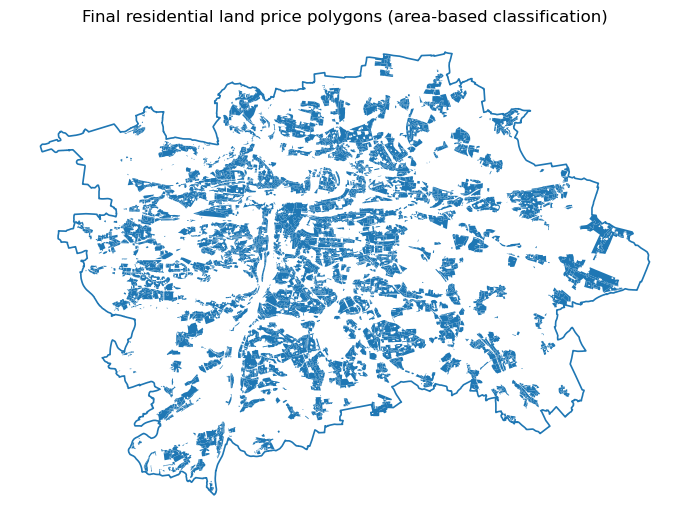

In [87]:
# QC map: residential land price polygons
qc_plot_layer(
    res,
    boundary=prague_boundary,
    title="Final residential land price polygons (area-based classification)",
    linewidth=0.3
)


#### **Transition to exploratory analysis**

This residential land price dataset serves as the input for the subsequent exploratory spatial analysis. 
    
The next stage focuses on visual inspection of land price patterns, transport accessibility measures, and initial evidence of spatial clustering, without imposing formal modelling assumptions.

## 9. Preprocessing outputs

At the end of this notebook, the following datasets are produced and stored for downstream analysis:

- Prague boundary polygon
- Mode-specific public transport routes
- Mode-specific public transport stops
- Residential land price polygons (filtered using the land-use plan)

All subsequent notebooks operate exclusively on these preprocessed datasets.